<h1><center>NIH MEG Workshop 2023 Preprocessing </center></h1> 

## General Import and settings

In [25]:
import mne
import mne_bids
import os, os.path as op
import numpy as np
import warnings
import copy
import matplotlib.pyplot as plt

# warnings.filterwarnings('ignore', '.*Use of `point_arrays` is deprecated.*',)
# warnings.filterwarnings('ignore', '.*Matplotlib.*',) 

# Setup Paths

## Set some generic BIDS information
BIDS is a "new" standard for formatting neuroimaging/neurophysiology data <br>
The bids_root is the top level, derivatives holds the projects, project level has the outputs for each subject

| Folder | Data Type | 
| --- | --- | 
| bids_root | raw data |
| deriv_root | folders for all possible derivatives | 
| project_root | [Derivatives]: output folder for this processing | 
| subjects_dir | [Derivatives]: freesurfer anatomical information | 

In [2]:
#Raw data
bids_root = op.join('/data/', os.environ['USER'], 'meg_workshop_data')  
#Processed Data Folder: contains (freesurfer / Day1 / Day2) 
deriv_root = op.join(bids_root, 'derivatives')
if not op.exists(deriv_root): os.mkdir(deriv_root)
#This course data - bids derivatives outputs for Day1 
project_root = op.join(deriv_root, 'Day1') 
#Freesurfer brain surface reconstruction
fs_subjects_dir = op.join(deriv_root, 'freesurfer','subjects')
subjects_dir = fs_subjects_dir

### Find data for a subject

In [3]:
subject = 'ON02811'
bids_path = mne_bids.BIDSPath(root=bids_root, subject = subject, session='01', task='airpuff', run='01', datatype='meg')
project_path = bids_path.copy().update(root=project_root, check=False)
if not op.exists(project_path.root): os.mkdir(project_path.root)

t1_bids_path = bids_path.copy().update(datatype='anat', session='01', task=None, run=None, suffix='T1w', acquisition='MPRAGE', extension='.nii.gz')
print(f'Here is the meg data file: {bids_path.fpath}')
print(f'Here is the t1 MRI file: {t1_bids_path.fpath}')

Here is the meg data file: /data/stoutjd/meg_workshop_data/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_meg.ds
Here is the t1 MRI file: /data/stoutjd/meg_workshop_data/sub-ON02811/ses-01/anat/sub-ON02811_ses-01_acq-MPRAGE_T1w.nii.gz


## Load the MEG file

In [4]:
# Using the BIDS reader -- same as below
raw = mne_bids.read_raw_bids(bids_path)

ds directory : /data/stoutjd/meg_workshop_data/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -1.82   70.43    0.00 mm <->   -1.82   70.43    0.00 mm (orig :  -45.24   54.14 -275.77 mm) diff =    0.000 mm
       1.82  -70.43    0.00 mm <->    1.82  -70.43    0.00 mm (orig :   62.56  -36.39 -269.47 mm) diff =    0.000 mm
      90.00    0.00    0.00 mm <->   90.00   -0.00   -0.00 mm (orig :   65.74   74.78 -250.30 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /data/stoutjd/meg_workshop_data/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_meg.ds/sub-ON02811_ses-01_task-airpuff_run-01_meg.meg4: 
    System clock channel is available, checking which s

/tmp/ipykernel_1014416/3128652160.py:2: RuntimeWarning: The unit for channel(s) SCLK01-177, UADC001, UPPT001, trigger has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_1014416/3128652160.py:2: RuntimeWarning: participants.tsv file not found for /data/stoutjd/meg_workshop_data/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_meg.ds
  raw = mne_bids.read_raw_bids(bids_path)


In [5]:
# Load the data with the traditional reader -- same as above
# raw = mne.io.read_raw_ctf(bids_path.fpath, clean_names=True, system_clock='ignore')

In [6]:
raw.info        #Note that this data has been anonymized (dates and names are scrubbed)

<Info | 15 non-empty values
 bads: []
 ch_names: SCLK01-177, BG1, BG2, BG3, BP1, BP2, BP3, BR1, BR2, BR3, G11, ...
 chs: 4 misc, 28 Reference Magnetometers, 272 Magnetometers
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 line_freq: 60.0
 lowpass: 600.0 Hz
 meas_date: 1911-11-11 11:11:00 UTC
 meas_id: 4 items (dict)
 nchan: 304
 projs: []
 sfreq: 1200.0 Hz
>

| Channel Types | Function | |
| --- | --- | --- |
| MEG  |  MEG   | Collect Brain Signal |
| Ref   | Reference Channels | Used for third Order Gradient to reject artifact | 
| UPPT | Digital Trigger  - Parrallel Port | designates trigger value - Up to 256| 
| UADC | Analog Triggers |  designates timing - eg Projector Trigger |  


#### 3rd Order Gradiometers applied - In our case 3rd order compensation is set by default during acquisition

In [7]:
raw.compensation_grade

3

## Plot **without** 3rd Order Gradient Compensation

In [8]:
%matplotlib inline
_=raw.copy().apply_gradient_compensation(1).plot(n_channels=10)

Compensator constructed to change 3 -> 1
Using qt as 2D backend.


QStandardPaths: error creating runtime directory '/run/user/39412' (Permission denied)


Channels marked as bad:
none


## Plot **with** 3rd Order Gradient

In [9]:
print('3rd Order Gradient applied')
_=raw.plot(n_channels=10)

3rd Order Gradient applied
Channels marked as bad:
none


In [64]:
raw.load_data()
print(f'The data consists of a matrix: {raw._data.shape[0]} channels by {raw._data.shape[1]} samples')
print(f"This is samples / sampling frequency: {raw._data.shape[1]/raw.info['sfreq']} seconds")

The data consists of a matrix: 304 channels by 301200 samples
This is samples / sampling frequency: 251.0 seconds


## Channel information

![SensorLayout](images/sens_layout.png)

In [24]:
print('Some examples of channel names')
raw.ch_names[50:110:5]

Some examples of channel names


['MLC61',
 'MLF13',
 'MLF24',
 'MLF35',
 'MLF45',
 'MLF54',
 'MLF63',
 'MLO11',
 'MLO22',
 'MLO33',
 'MLO44',
 'MLP12']

### Selecting channels

In [37]:
# Also look at raw.pick_channels and raw.pick
raw.pick_types?

Signature:
raw.pick_types(
    meg=False,
    eeg=False,
    stim=False,
    eog=False,
    ecg=False,
    emg=False,
    ref_meg='auto',
    *,
    misc=False,
    resp=False,
    chpi=False,
    exci=False,
    ias=False,
    syst=False,
    seeg=False,
    dipole=False,
    gof=False,
    bio=False,
    ecog=False,
    fnirs=False,
    csd=False,
    dbs=False,
    temperature=False,
    gsr=False,
    eyetrack=False,
    include=(),
    exclude='bads',
    selection=None,
    verbose=None,
)
Docstring:
.. warning:: LEGACY: New code should use inst.pick(...).

Pick some channels by type and names.

Parameters
----------

meg : bool | str
    If True include MEG channels. If string it can be 'mag', 'grad',
    'planar1' or 'planar2' to select only magnetometers, all
    gradiometers, or a specific type of gradiometer.
eeg : bool
    If True include EEG channels.
stim : bool
    If True include stimulus channels.
eog : bool
    If True include EOG channels.
ecg : bool
    If True incl

In [63]:
# raw.pick?

In [58]:
raw.info

<Info | 15 non-empty values
 bads: []
 ch_names: BG1, BG2, BG3, BP1, BP2, BP3, BR1, BR2, BR3, G11, G12, G13, G22, ...
 chs: 28 Reference Magnetometers, 272 Magnetometers
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 lowpass: 600.0 Hz
 meas_date: 1911-11-11 11:11:00 UTC
 meas_id: 4 items (dict)
 nchan: 300
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>

In [76]:
raw.pick_types(meg=True, eeg=False, misc=True)._data.shape

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


AttributeError: 'RawCTF' object has no attribute '_data'

In [49]:
print(f'There are {raw.copy().pick_types(meg=True, ref_meg=False)._data.shape[0]} meg channels and {raw.copy().pick_types(meg=False, ref_meg=True)._data.shape[0]} ref channels')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
There are 272 meg channels and 28 ref channels


## Processing Triggers

### The data is collected continuously while the subject is presented with stimuli (eg auditory, visual, somatosensory).  The triggers are then used to pull information from the continous dataset

In [33]:
print(f"UADC001 index: {raw.ch_names.index('UADC001')}")
print(f"UPPT001 index: {raw.ch_names.index('UPPT001')}")

UADC001 index: 301
UPPT001 index: 302


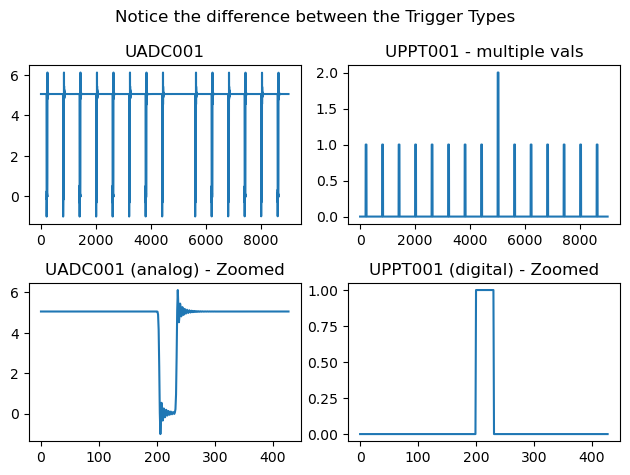

In [76]:
#General plotting using python plotting
%matplotlib inline
samp_start = 1000
samp_end = 10000
fig, ax = plt.subplots(2,2)
#Note the indexing from previous cell (301 is UADC, 302 is UPPT)
ax[0,0].plot(raw._data[301, samp_start:samp_end])   
ax[0,0].set_title('UADC001')
ax[0,1].plot(raw._data[302, samp_start:samp_end])
ax[0,1].set_title('UPPT001 - multiple vals')
ax[1,0].plot(raw._data[301, samp_start:int(samp_end/7)])
ax[1,0].set_title('UADC001 (analog) - Zoomed')
ax[1,1].plot(raw._data[302, samp_start:int(samp_end/7)])
ax[1,1].set_title('UPPT001 (digital) - Zoomed')
fig.suptitle('Notice the difference between the Trigger Types')
fig.tight_layout()

### Somatosensory task - Airpuff Stimulus (Stim) vs. Missing Stim 
### UPPT001 codes stimuli; UADC001 communicates to mechanical airpuff delivery system

In [ ]:
%matplotlib qt
#Set scalings by data type - eg scalings={'mag':300} for evoked meg data
misc1.plot(scalings={'misc':10}, duration=4)  

In [ ]:
front = [i for i in raw.ch_names if i[2]=='F']
print(f'There are {len(front)} frontal channels')

In [ ]:
front_data = raw.copy().pick_channels(front)

In [ ]:
%matplotlib qt
front_data.plot()

### Sensor level preprocessing

In [ ]:
raw = raw.load_data() 

# Creating Events and Epochs from the data

In [66]:
raw.annotations  #These have been read from the MarkerFile.mrk upon reading 

<Annotations | 500 segments: missingstim (75), stim (425)>

In [67]:
events, event_ids = mne.events_from_annotations(raw) 

Used Annotations descriptions: ['missingstim', 'stim']


In [68]:
# Dictionary that maps event name to event code
event_ids

{'missingstim': 1, 'stim': 2}

In [72]:
events    # [Sample , duration, stim_code]

array([[  1254,      0,      2],
       [  1854,      0,      2],
       [  2454,      0,      2],
       ...,
       [299458,      0,      2],
       [300054,      0,      1],
       [300658,      0,      2]])

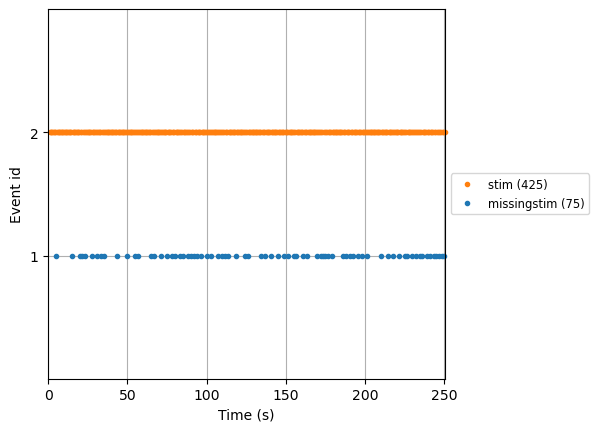

In [73]:
%matplotlib inline
_ = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_ids)

## Epochs: Time windows of data around each event 

In [96]:
#At time 0ms the stimuli is delivered
tmin=-0.1  #100ms before event
tmax=0.2   #300ms after event

#Calculate all epochs with no rejection
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, reject_tmax=0,
                preload=True, baseline=(tmin, 0))


Not setting metadata
500 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 361 original time points ...
0 bad epochs dropped


In [97]:
print('Number of Epochs X Number of Channels X Number of samples')
print(epochs._data.shape)

Number of Epochs X Number of Channels X Number of samples
(500, 304, 361)


In [98]:
%matplotlib qt
_=epochs.plot(n_channels=10, events=False)

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


### Rejecting bad epochs using amplitude thresholding

In [99]:
reject_dict = {'mag':2500e-15}
cleaned=epochs.copy().drop_bad(reject=reject_dict)

    Rejecting  epoch based on MAG : ['MRT22']
    Rejecting  epoch based on MAG : ['MRT22']
    Rejecting  epoch based on MAG : ['MRT14']
    Rejecting  epoch based on MAG : ['MRT13', 'MRT23']
    Rejecting  epoch based on MAG : ['MLT11', 'MLT12', 'MLT22', 'MLT23', 'MLT24', 'MLT32', 'MLT33', 'MLT34', 'MLT42']
    Rejecting  epoch based on MAG : ['MRT11', 'MRT12', 'MRT22']
6 bad epochs dropped


### Epochs data size: Epochs X Channels X TimeSteps

In [100]:
print(f'Original Data Size:{epochs._data.shape}')
print(f'Cleaned  Data Size:{cleaned._data.shape}')
print('The matrix is now 6 epochs less')

Original Data Size:(500, 304, 361)
Cleaned  Data Size:(494, 304, 361)
The matrix is now 6 epochs less


### Evoked data averages over epochs: Channels X TimeSteps

In [101]:
evoked = epochs['2'].average()
evoked._data.shape  #Also removes 4 response/stim/clock channels
print('The evoked data averages all of the epochs')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
The evoked data averages all of the epochs


### Butterfly plot of evoked brain activity

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


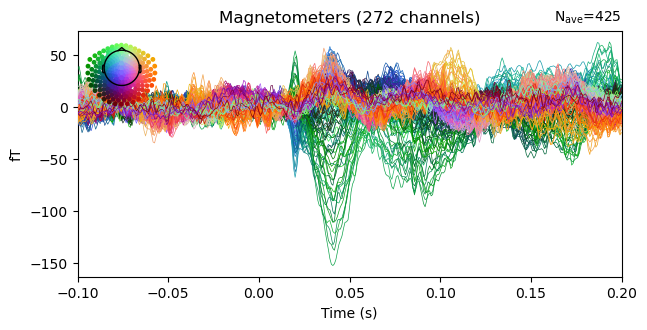

In [102]:
%matplotlib inline
_=evoked.plot()

### Plot evoked dataset over time

Removing 5 compensators from info because not all compensation channels were picked.


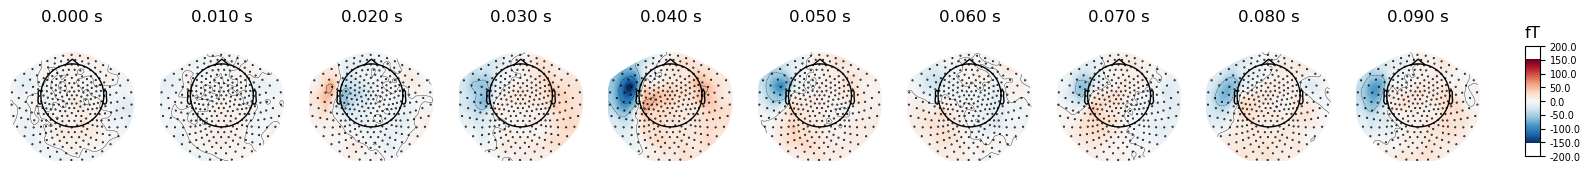

In [103]:
_=evoked.plot_topomap(times=np.arange(0,.1, 0.01))

### Effect of number of samples on data average

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


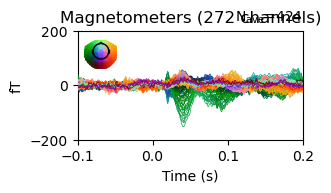

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


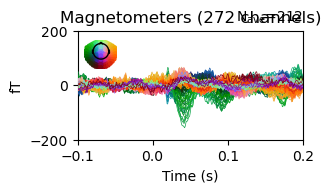

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


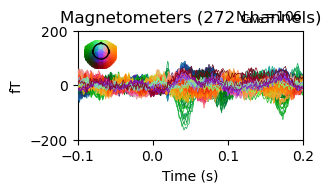

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


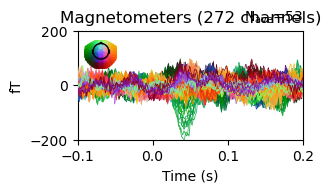

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


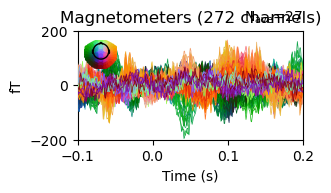

<Figure size 640x480 with 0 Axes>

In [106]:
stim_epochs=epochs['2']


Rows = Tot // Cols 

#     EDIT for correct number of rows:
#     If one additional row is necessary -> add one:

if Tot % Cols != 0:
    Rows += 1

%matplotlib inline
fig,ax = plt.subplots(3,2)
rows=0
for idx,num in enumerate([1,2,4,8,16]):
    if idx % 2 !=0:
        rows += 1
    ax[rows,  = plt.subplot(3,2,idx+1)
    evoked = stim_epochs[0:-1:num].average(method='mean')
    evoked.plot(axes=ax, ylim={'mag':[-200,200]}, verbose=False)
plt.tight_layout()
plt.show()


In [ ]:
from matplotlib import pyplot as plt

stim_epochs=epochs['2']

%matplotlib qt
fig = plt.Figure()
for idx,num in enumerate([1,2,4,8,16]):
    ax = plt.subplot(3,2,idx+1)
    evoked = stim_epochs[0:-1:num].average(method='mean')
    evoked.plot_topomap(times=[0.040], colorbar=False, vmin=-100, vmax=100, axes=ax)
    plt.title(f'40ms - Number Ave:{evoked.nave}')
plt.tight_layout()
plt.show()layout()
plt.show()layout()
plt.show()
